# Functions

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda

# ============================================== REMOVEEEEEEEEEEEEEE THISSSSSSSSSS ===============================================
import warnings
from numba import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

np.random.seed(42)
hidden_size = 50

In [2]:
# Temporarily replace np.random.randn() -> Need to re-implement
def randn(x, y):
  return np.array([[0.5 if (u+i)%2==0 else -0.5 for u in range(y)] for i in range(x)])

In [3]:
def generate_dataset(num_sequences = 50, max_num_each_token = 5):
    samples = []
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, max_num_each_token)
        sample = ['A'] * num_tokens + ['B'] * num_tokens + ['EOS']
        samples.append(sample)
    return samples

# Function: List of sequences -> word_to_idx, idx_to_word, num_sentences, vocab_size
def sequences_to_dicts(sequences):
    flatten = lambda l: [item for sublist in l for item in sublist] # Flatten a nested list
    all_words = flatten(sequences)
    # Count number of word occurences
    word_count = {}
    for word in flatten(sequences):
        word_count[word] = 0
    for word in flatten(sequences):
        word_count[word] = word_count[word] + 1
    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    # Add UNK token to list of words
    unique_words.append('UNK')
    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)
    # Create dictionaries so that we can go from word to index and back
    word_to_idx = {}
    idx_to_word = {}
    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    return word_to_idx, idx_to_word, num_sentences, vocab_size

# Function: Create and split dataset into Train/Val/Test set
def create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1):
    # Train/Val/Test ratio
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)
    # Split sequences into Train/Val/Test
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]
    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
        return inputs, targets
    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
    # Create datasets
    training_set = [(inputs_train[i], targets_train[i]) for i in range(len(inputs_train))]
    validation_set = [(inputs_val[i], targets_val[i]) for i in range(len(inputs_val))]
    test_set = [(inputs_test[i], targets_test[i]) for i in range(len(inputs_test))]    
    return training_set, validation_set, test_set

In [4]:
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1.0
    return one_hot

def one_hot_encode_sequence(sequence, vocab_size):
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

In [5]:
def init_orthogonal(param):
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")
    rows, cols = param.shape
    new_param = randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    return new_param


def init_rnn(hidden_size, vocab_size):
    U = np.zeros((hidden_size, vocab_size))
    V = np.zeros((hidden_size, hidden_size))
    W = np.zeros((vocab_size, hidden_size))
    b_hidden = np.zeros((hidden_size, 1))
    b_out = np.zeros((vocab_size, 1))
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    return U, V, W, b_hidden, b_out

In [6]:
def sigmoid(x, derivative=False):
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    if derivative:
        return f * (1 - f)
    else:
        return f

def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    if derivative:
        return 1-f**2
    else:
        return f

def softmax(x, derivative=False):
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    if derivative:
        pass
    else:
        return f

def clip_gradient_norm(grads, max_norm=0.25):
    max_norm = float(max_norm)
    total_norm = 0
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    total_norm = np.sqrt(total_norm)
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    return grads

def update_parameters(params, grads, lr=1e-3):
    for param, grad in zip(params, grads):
        param -= lr * grad
    return params

In [7]:
def forward_pass(inputs, h, params):
    U, V, W, b_hidden, b_out = params
    outputs, hidden_states = [0] * len(inputs), [0] * len(inputs)
    for t in range(len(inputs)):
        h = tanh(np.dot(U, inputs[t]) + np.dot(V, h) + b_hidden)
        outputs[t] = softmax(np.dot(W, h) + b_out)
        hidden_states[t] = h
    return outputs, hidden_states

def backward_pass(inputs, outputs, h_s, targets, params):
    U, V, W, b_hidden, b_out = params
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    d_h_next = np.zeros_like(h_s[0])
    loss = 0
    for t in reversed(range(len(outputs))):
        loss = loss - np.mean(np.log(outputs[t]+1e-12) * targets[t])
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] = d_o[np.argmax(targets[t])] - 1
        d_W = d_W + np.dot(d_o, h_s[t].T)
        d_h = np.dot(W.T, d_o) + d_h_next
        d_f = tanh(h_s[t], derivative=True) * d_h
        d_b_hidden = d_b_hidden + d_f
        d_U = d_U + np.dot(d_f, inputs[t].T)
        d_V = d_V + np.dot(d_f, h_s[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    grads = clip_gradient_norm(grads)
    return loss, grads

# Dataset

Example sequence: ['A', 'A', 'B', 'B', 'EOS']



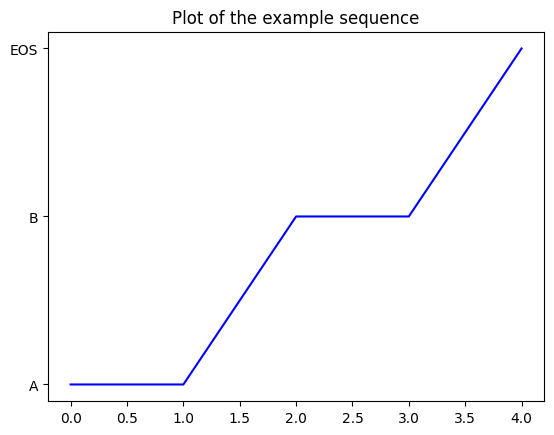



Num of sequences (Dataset size):	20 sequences
Num of tokens (Vocab size):		4 tokens

word_to_idx:
'A' -> 0
'B' -> 1
'EOS' -> 2
'UNK' -> 3

idx_to_word:
0 -> 'A'
1 -> 'B'
2 -> 'EOS'
3 -> 'UNK'

Dataset splitting:
Train:		16 samples
Validation:	2 samples
Test:		2 samples


In [8]:
# Initialize dataset
sequences = generate_dataset(num_sequences = 20, max_num_each_token = 3) # 20 / 3
word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)
training_set, validation_set, test_set = create_datasets(sequences)

# One-hot Encoding set
training_set_one_hot = []
validation_set_one_hot = []
for idx, (inputs, targets) in enumerate(training_set):
    inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
    targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
    training_set_one_hot.append((inputs_one_hot, targets_one_hot))
for idx, (inputs, targets) in enumerate(validation_set):
    inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
    targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
    validation_set_one_hot.append((inputs_one_hot, targets_one_hot))
training_set_one_hot = tuple(training_set_one_hot)
validation_set_one_hot = tuple(validation_set_one_hot)

# Print
print(f"Example sequence: {sequences[1]}\n")

plt.plot(sequences[1], color='blue')
plt.title('Plot of the example sequence')
plt.show()

print(f"\n\nNum of sequences (Dataset size):\t{num_sequences} sequences")
print(f"Num of tokens (Vocab size):\t\t{vocab_size} tokens")
print("\nword_to_idx:")
for item in word_to_idx:
  print(f"'{item}' -> {word_to_idx[item]}")
print("\nidx_to_word:")
for item in idx_to_word:
  print(f"{item} -> '{idx_to_word[item]}'")
print(f"\nDataset splitting:")
print(f'Train:\t\t{len(training_set)} samples')
print(f'Validation:\t{len(validation_set)} samples')
print(f'Test:\t\t{len(test_set)} samples')

# Train LSTM

In [9]:
def train_LSTM(num_epochs = 100, learning_rate = 10e-1, hidden_size = hidden_size, vocab_size = vocab_size):

    # Initialize a new network
    params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))

    # Track loss
    training_loss, validation_loss = [], []

    # For each epoch
    for i in range(num_epochs+1):
        
        # Track loss
        epoch_training_loss = 0
        epoch_validation_loss = 0

        all_grads = [0] * len(training_set)
        all_train_losses = np.zeros(len(training_set))
        all_valid_losses = np.zeros(len(validation_set))
        
        # For each sentence in validation set
        for idx, (inputs, targets) in enumerate(validation_set):
            # One-hot encode input and target sequence
            inputs_one_hot = validation_set_one_hot[idx][0]
            targets_one_hot = validation_set_one_hot[idx][1]
            # Re-initialize hidden state
            hidden_state = np.zeros_like(hidden_state)
            # Forward pass
            outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
            # Backward pass
            loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
            # Save loss
            all_valid_losses[idx] = loss
        
        # For each sentence in training set
        for idx, (inputs, targets) in enumerate(training_set):
            # One-hot encode input and target sequence
            inputs_one_hot = training_set_one_hot[idx][0]
            targets_one_hot = training_set_one_hot[idx][1]
            # Re-initialize hidden state
            hidden_state = np.zeros_like(hidden_state)
            # Forward pass
            outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
            # Backward pass
            loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
            # Save loss
            all_train_losses[idx] = loss
            # Save grads
            all_grads[idx] = grads
            
        # Calculate mean of grads + Update params
        avg_grads = np.mean(all_grads, axis = 0)
        params = update_parameters(params, avg_grads, lr = learning_rate)

        # Calculate sum of losses
        epoch_training_loss = np.sum(all_train_losses)
        epoch_validation_loss = np.sum(all_valid_losses)

        # Save loss for plot
        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

        # Print loss
        if i % 5 == 0:
            print(f'Epoch {i}:\tTrain Loss = {round(training_loss[-1], 2)}\tValid Loss = {round(validation_loss[-1], 2)}')
            if training_loss[-1] == 0.5210244780986917 and validation_loss[-1] == 1.0045486973360829:
                print(f'👍👍👍👍👍👍👍👍👍👍\n' * 10)

    return params

In [10]:
params = train_LSTM(num_epochs = 5, learning_rate = 10e-1)

Epoch 0:	Train Loss = 0.93	Valid Loss = 1.28
Epoch 5:	Train Loss = 0.52	Valid Loss = 1.0
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍
👍👍👍👍👍👍👍👍👍👍



# Test

In [11]:
# def inference(params, sentence='', num_generate=15):
#     sentence = sentence.split(' ')
#     sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
#     hidden_state = np.zeros((hidden_size, 1))
#     outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
#     output_sentence = sentence
#     word = idx_to_word[np.argmax(outputs[-1])]    
#     output_sentence.append(word)
#     for i in range(num_generate):
#         output = outputs[-1]
#         hidden_state = hidden_states[-1]
#         output = output.reshape(1, output.shape[0], output.shape[1])
#         # Forward pass
#         outputs, hidden_states = forward_pass(output, hidden_state, params)
#         word = idx_to_word[np.argmax(outputs)]
#         output_sentence.append(word)
#     return output_sentence

# prediction = inference(params, sentence='A A A A B')
# plt.plot(prediction)
# plt.show()
# print(prediction)